In [1]:
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob


from keras.models import Sequential, load_model
from keras.layers import Lambda, Conv2D, Input, LeakyReLU, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [74]:
cars = glob.glob('./data/vehicles/GTI_Far/*')
cars = glob.glob('./data/vehicles/GTI_Left/*')

cars.extend(glob.glob('./data/vehicles/GTI_MiddleClose/*'))
cars.extend(glob.glob('./data/vehicles/GTI_Right/*'))
cars.extend(glob.glob('./data/vehicles/KITTI_extracted/*'))
# cars.extend(glob.glob('./data/vehicles/project_video_extracted/*'))

cars.extend(glob.glob('./data/udacity_car_extracted/*')[200:800])

notcars = glob.glob('./data/non-vehicles/GTI/*')[300:-100]
notcars.extend(glob.glob('./data/non-vehicles/Extras/*')[550:-100])
# notcars.extend(glob.glob('./data/udacity_notcar_extracted/*'))



# # get a small sample for test
# cars = cars[:500]
# notcars = notcars[:2000]


print('Number of vehicle images: ', len(cars), '  image shape: ', mpimg.imread(cars[0]).shape)
print('Number of non-vehicle images: ', len(notcars), '  image shape: ', mpimg.imread(notcars[0]).shape)

Number of vehicle images:  8558   image shape:  (64, 64, 3)
Number of non-vehicle images:  7918   image shape:  (64, 64, 3)


In [75]:
car_features = [] # list of 64*64 images
notcar_features = []

for img in cars:
    car_img = mpimg.imread(img)
    car_resized = cv2.resize(car_img, (64, 64))
    
    # for udacity_extracted_data, the image shape is (64, 64, 4). so need to remove the last channel
    if car_resized.shape[2] == 4:
        car_resized = car_resized[:,:,:3]
    # augment feature by flipping over
    img_flipped = np.fliplr(car_resized)
    
    car_features.append(car_resized)
    car_features.append(img_flipped)

for img in notcars:
    notcar_img = mpimg.imread(img)
    notcar_resized = cv2.resize(notcar_img, (64, 64))
    # augment feature by flipping over
    img_flipped = np.fliplr(notcar_resized)
    
    notcar_features.append(notcar_resized)
    notcar_features.append(img_flipped)

assert len(car_features) == (2 * len(cars))
assert len(notcar_features) == (2 * len(notcars))

In [76]:
print('Number of vehicle features: ', len(car_features), '  image shape: ', car_features[0].shape)
print('Number of non-vehicle features: ', len(notcar_features), '  image shape: ', notcar_features[0].shape)

Number of vehicle features:  17116   image shape:  (64, 64, 3)
Number of non-vehicle features:  15836   image shape:  (64, 64, 3)


In [77]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
y = to_categorical(y)


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [78]:
model = Sequential()


model.add(Conv2D(8, kernel_size=5, strides=(2, 2), kernel_initializer='random_uniform', input_shape=(64,64,3)))
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Conv2D(16, kernel_size=5, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, kernel_size=3, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, kernel_size=2, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(Dropout(0.3))


model.add(Conv2D(128, kernel_size=2, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())

model.add(Flatten())

model.add(Dense(1388))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Dense(32))
model.add(LeakyReLU())

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')




In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 30, 30, 8)         608       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 26, 26, 16)        3216      
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 32)        4640      
__________

In [80]:
epochs = 30
batch_size = 64

filepath = 'ConvNet_augmented_data.h5'
save_best = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


In [81]:
training_log = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=epochs, batch_size=batch_size, callbacks=[save_best])


Train on 21088 samples, validate on 5273 samples
Epoch 1/30
21088/21088 [==============================] - 113s - loss: 0.2983 - val_loss: 0.1276
Epoch 2/30
21088/21088 [==============================] - 79s - loss: 0.1115 - val_loss: 0.1357
Epoch 3/30
21088/21088 [==============================] - 72s - loss: 0.0790 - val_loss: 0.0590
Epoch 4/30
21088/21088 [==============================] - 71s - loss: 0.0671 - val_loss: 0.0434s: 0.06
Epoch 5/30
21088/21088 [==============================] - 74s - loss: 0.0562 - val_loss: 0.0688 - ETA: 1s - loss:
Epoch 6/30
21088/21088 [==============================] - 71s - loss: 0.0502 - val_loss: 0.0395
Epoch 7/30
21088/21088 [==============================] - 71s - loss: 0.0419 - val_loss: 0.0367
Epoch 8/30
21088/21088 [==============================] - 71s - loss: 0.0396 - val_loss: 0.0343
Epoch 9/30
21088/21088 [==============================] - 71s - loss: 0.0338 - val_loss: 0.0233
Epoch 10/30
21088/21088 [==============================] - 73

6591/6591 [==============================] - 13s    
Test score Loss:  0.0174695827939


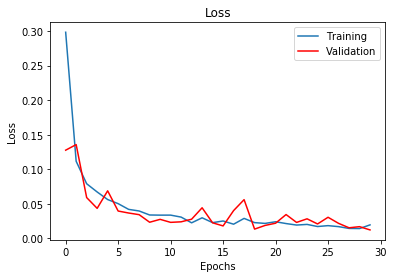

In [82]:
loss_score = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score Loss: ', loss_score)
# print('Test accuracy:', acc)

# show the loss and accuracy
loss = training_log.history['loss']
val_loss = training_log.history['val_loss']




# loss plot
plt.plot(loss)
plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()


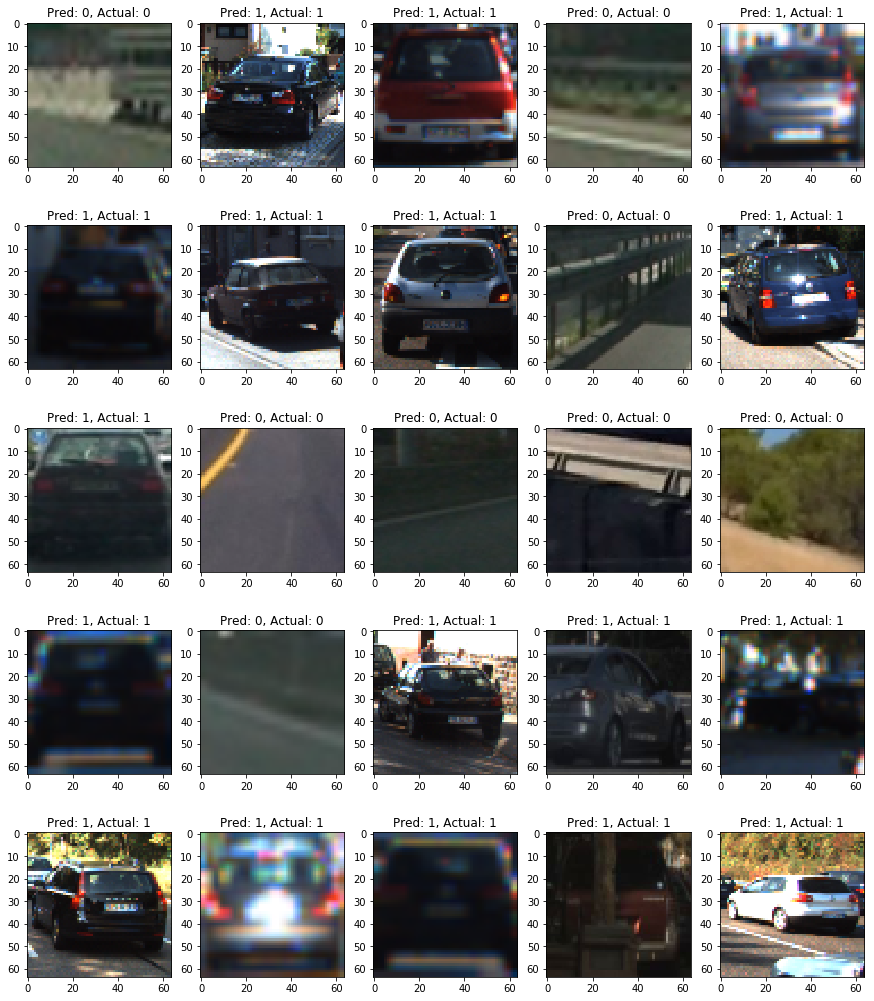

In [84]:

f, axes = plt.subplots(5, 5, figsize=(15, 18))

for axe in axes:
    for plot in axe:
        i = np.random.randint(len(X_test))
        plot.imshow(X_test[i])
        
        # prediction
        shape = X_test[i].shape
        pred_label = model.predict(X_test[i].reshape((1, shape[0], shape[1], shape[2])))
        plot.set_title('Pred: {}, Actual: {}'.format(np.argmax(pred_label), np.argmax(y_test[i])))

In [85]:
class VehicleDetector(object):
    def __init__(self, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.svc = svc
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
    
    
    
    def find_cars(self, img):

        ystart = self.ystart
        ystop = self.ystop
        scale = self.scale
        svc = self.svc
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
#         ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = img_tosearch[:,:,0]
        ch2 = img_tosearch[:,:,1]
        ch3 = img_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

#         # Compute individual channel HOG features for the entire image
#         hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
#                 # Extract HOG for this patch
#                 hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                subimg = subimg.reshape((1, subimg.shape[0], subimg.shape[1], subimg.shape[2]))
#                 # Get color features
#                 spatial_features = bin_spatial(subimg, size=spatial_size)
#                 hist_features = color_hist(subimg, nbins=hist_bins)

#                 # Scale features and make a prediction
#                 test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                
                test_prediction = svc.predict(subimg)

                if test_prediction[0][1] > 0.65:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

#                 bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
        return draw_img
    
ystart = 400
ystop = 656
scale = 1.5

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins


detector = VehicleDetector(ystart, ystop, scale, model, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

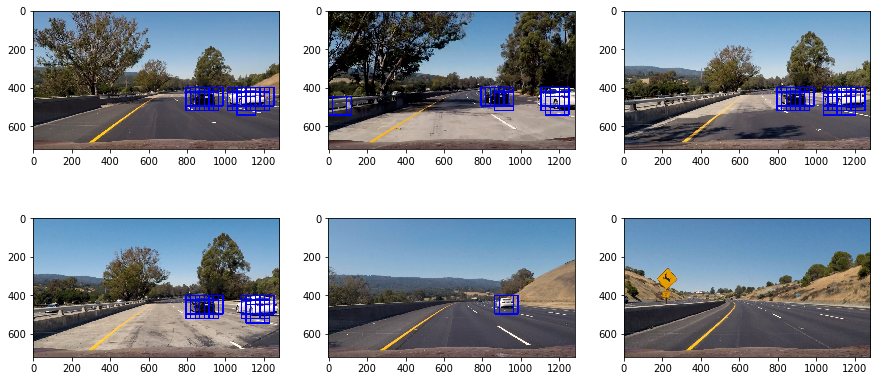

In [86]:
test_images = glob.glob('./test_images/*')

    
f, axes = plt.subplots(2, 3, figsize=(15, 7))

i = 0
for axe in axes:
    for plot in axe:
        img = mpimg.imread(test_images[i])
        out_img = detector.find_cars(img)
        plot.imshow(out_img)
        i += 1

## checkpoint


In [87]:
from keras.models import load_model
model = load_model('ConvNet_augmented_data.h5')

In [91]:
class VehicleDetector(object):
    def __init__(self, ystart, ystop, scale, model, pix_per_cell, cell_per_block, thresh):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.model = model

        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        
        self.thresh = thresh
        
#         self.bboxes = [None, None] # [box1, box2]
    
    
    # single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img):

        ystart = self.ystart
        ystop = self.ystop
        scale = self.scale
        model = self.model

        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block

        
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        if scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = img_tosearch[:,:,0]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step


        bboxes = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                subimg = subimg.reshape((1, subimg.shape[0], subimg.shape[1], subimg.shape[2]))
                
                test_prediction = model.predict(subimg)

                if test_prediction[0][1] > 0.6:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#         return draw_img
        return bboxes

        
    # function to draw the boxes with heatmap applied
    def draw_labeled_bboxes(self, img):
        
        _, labels = self.find_heatmap(img)
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
#             bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            bbox = [(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))]
           

            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    # function to find and return heatmap and labels
    def find_heatmap(self, img):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        ''''''
        thresh = self.thresh
        
        box_list = self.find_cars(img)
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat,thresh)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        return heatmap, labels
    
    def draw_heatmap(self, img):
        '''function for passing into videoclip'''
        
        thresh = self.thresh
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        box_list = self.find_cars(img)
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat,thresh)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        return heatmap    
ystart = 400
ystop = 656
scale = 1.5

thresh = 1


pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

detector = VehicleDetector(ystart, ystop, scale, model, pix_per_cell, cell_per_block, thresh)






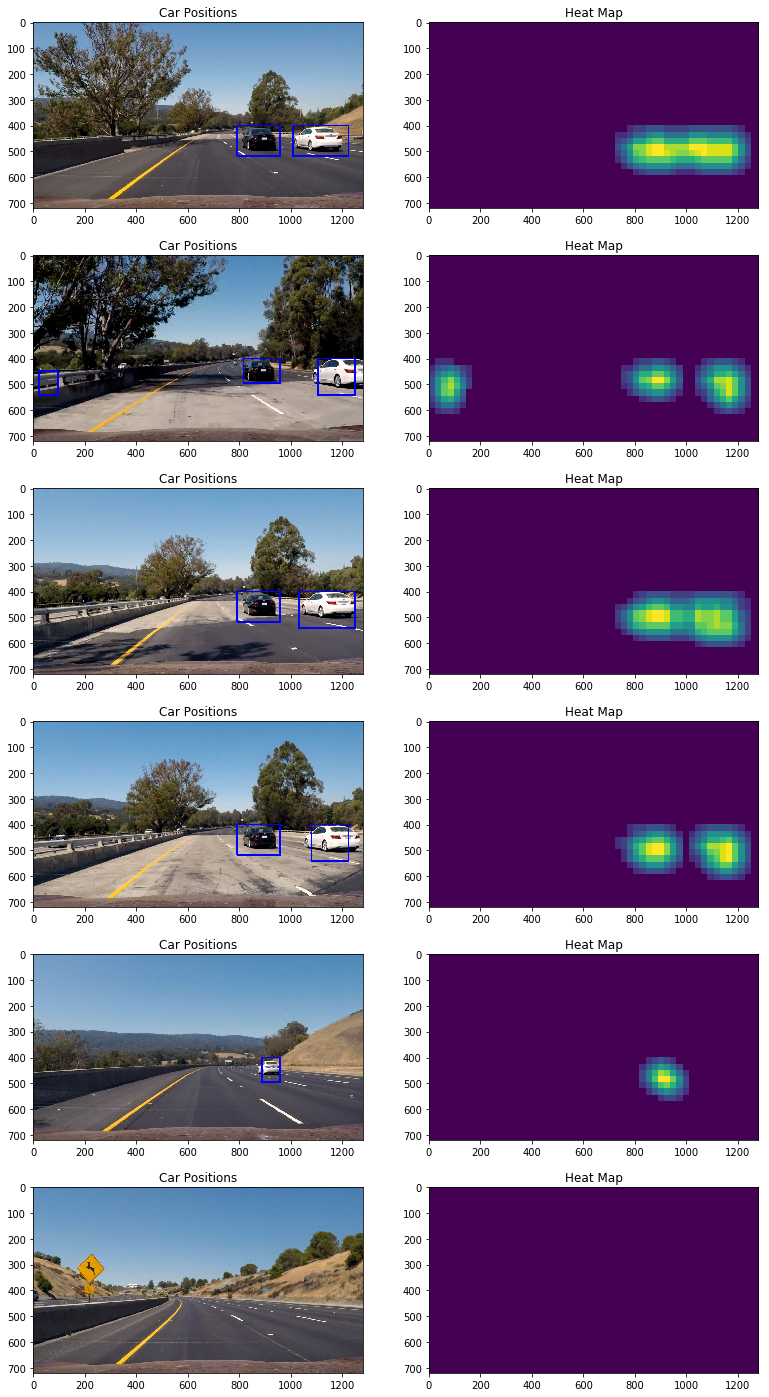

In [92]:
test_images = glob.glob('./test_images/*')


    
f, axes = plt.subplots(6, 2, figsize=(13, 25))

i = 0
for axe in axes:
    img = mpimg.imread(test_images[i])
    
    draw_img = detector.draw_labeled_bboxes(img)
    heatmap, _ = detector.find_heatmap(img)    
    
    axe[0].imshow(draw_img)
    axe[0].set_title('Car Positions')
    axe[1].imshow(heatmap)
    axe[1].set_title('Heat Map')
    i += 1




In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
clip1 = VideoFileClip('./test_video.mp4')
white_clip = clip1.fl_image(detector.draw_labeled_bboxes) 
output_video = 'test_heatmap.mp4'
%time white_clip.write_videofile(output_video, audio=False)

In [94]:
# clip1 = VideoFileClip('./test_video.mp4')


clip1 = VideoFileClip('./project_video.mp4')
# clip1 = VideoFileClip('./p4-output.mov')

white_clip = clip1.fl_image(detector.draw_labeled_bboxes) 
output_video = 'ConvNet_augmented.mp4'
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ConvNet_augmented.mp4
[MoviePy] Writing video ConvNet_augmented.mp4


100%|█████████▉| 1260/1261 [18:29<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ConvNet_augmented.mp4 

CPU times: user 27min 54s, sys: 3min 17s, total: 31min 11s
Wall time: 18min 30s


In [ ]:
# clip1 = VideoFileClip('./test_video.mp4')


clip1 = VideoFileClip('./project_video.mp4')

white_clip = clip1.fl_image(detector.find_heatmap) 
output_video = 'ConvNet_heatmap.mp4'
%time white_clip.write_videofile(output_video, audio=False)